# Todo

0. Improve model to 50% accuracy
1. Data Preprocessing (3 layer structure) [DONE]
2. Data Preprocessing (5 layer structure)
3. Building agent for the deep learning [Consider valid move]
4. Reading the reinforcement learning part

In [72]:
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
from tqdm.notebook import tqdm
import os
import aim
from aim.tensorflow import AimCallback 
from aim import Session

# Loading data

In [129]:
mat_files_X = sorted(["game_data/" + file for file in os.listdir("game_data/") if file.startswith("master_mat")])
raw_X = np.concatenate([np.load(file) for file in mat_files_X])
raw_X.shape

(148883, 8, 8)

In [130]:
mat_files_Y = sorted(["game_data/" + file for file in os.listdir("game_data/") if file.startswith("master_move")])
raw_Y = np.concatenate([np.load(file) for file in mat_files_Y])
raw_Y.shape

(148883, 8, 8)

In [131]:
np.save('Raw_X_full', raw_X)
np.save('Raw_Y_full', raw_Y)

In [75]:
from numba import jit

# No numba time: 13:52
@jit()
def potential_open_moves(game_state):

    mat = np.copy(game_state)

    master_X_open_self = []
    master_X_open_oppo = []

    for search_num in np.arange(4,1,-1):
        X_open_self = np.zeros((8,8))
        X_open_oppo = np.zeros((8,8))
        X_record_self = np.zeros((8,8))
        X_record_oppo = np.zeros((8,8))

        # Did not consider open and close siutation
        m = 8
        n=8
        for i in range(m):
            for j in range(m):

                if j + search_num+1 <= m:
                    sideway = mat[i][j:j+(search_num)]
                    if np.sum(sideway) ==search_num:
                        X_record_self[i][j:j+search_num] = 1

                        if mat[i][j-1] == 0:
                            X_open_self[i][j-1] = 1
                        if  mat[i][j+(search_num)] == 0:
                            X_open_self[i][j+(search_num)] = 1

                    if np.sum(sideway) == -search_num:
                        X_record_oppo[i][j:j+search_num] = 1

                        if mat[i][j-1] == 0:
                            X_open_oppo[i][j-1] = 1
                        if  mat[i][j+(search_num)] == 0:
                            X_open_oppo[i][j+(search_num)] = 1

                if i + search_num+1 <= m:
                    vert = mat[:,j][i:i+(search_num)]
                    if np.sum(vert) == search_num:
                        X_record_self[:,j][i:i+search_num] = 1

                        if mat[i-1][j] == 0:
                            X_open_self[i-1][j] = 1
                        if mat[i+(search_num)][j] == 0:
                            X_open_self[i+(search_num)][j] = 1

                    if np.sum(vert) == -search_num:
                        X_record_oppo[:,j][i:i+search_num] = 1

                        if mat[i-1][j] == 0:
                            X_open_oppo[i-1][j] = 1
                        if mat[i+(search_num)][j] == 0:
                            X_open_oppo[i+(search_num)][j] = 1


                if j + search_num+1 <= m and i + search_num+1 <= n:
                    diag = np.array([mat[i+x][j+y] for x in range(search_num) for y in range(search_num) if x == y])
                    if np.sum(diag) == search_num:
                        for k in range(search_num):
                            X_record_self[i+k][j+k] = 1


                        if mat[i-1][j-1] == 0:
                            X_open_self[i-1][j-1] = 1
                        if mat[i+(search_num)][j+(search_num)] == 0:
                            X_open_self[i+(search_num)][j+(search_num)] = 1

                    if np.sum(diag) == -search_num:
                        for k in range(search_num):
                            X_record_oppo[i+k][j+k] = 1

                        if mat[i-1][j-1] == 0:
                            X_open_oppo[i-1][j-1] = 1
                        if mat[i+(search_num)][j+(search_num)] == 0:
                            X_open_oppo[i+(search_num)][j+(search_num)] = 1

                if j - search_num >= 0 and i + search_num+1 <= n:
                    diag = np.array([mat[i+x][j-y] for x in range(search_num) for y in range(search_num) if x == y])
                    if np.sum(diag) == search_num:
                        for k in range(search_num):
                            X_record_self[i+k][j-k] = 1

                        if mat[i-1][j+1] == 0:
                            X_open_self[i-1][j-1] = 1
                        if  mat[i+(search_num)][j-(search_num)] == 0:
                            X_open_self[i+(search_num)][j-(search_num)] = 1
                    if np.sum(diag) == -search_num:
                        for k in range(search_num):
                            X_record_oppo[i+k][j-k] = 1


                        if mat[i-1][j+1] == 0:
                            X_open_oppo[i-1][j+1] = 1
                        if mat[i+(search_num)][j-(search_num)] == 0:
                            X_open_oppo[i+(search_num)][j-(search_num)] = 1

        i_axis = list(np.where(X_record_self==1)[0]) + list(np.where(X_record_oppo==1)[0])
        j_axis = list(np.where(X_record_self==1)[1]) + list(np.where(X_record_oppo==1)[1])

        for i,j in zip(i_axis, j_axis):
            mat[i][j] = 0

        master_X_open_self.append(np.copy(X_open_self))
        master_X_open_oppo.append(np.copy(X_open_oppo))
    return master_X_open_self + master_X_open_oppo

In [76]:
from numba import jit

# No numba time: 13:52
@jit()
def potential_open_moves(game_state):

    mat = np.copy(game_state)

    master_X_open_self = []
    master_X_open_oppo = []

    for search_num in np.arange(4,1,-1):
        X_open_self = np.zeros((8,8))
        X_open_oppo = np.zeros((8,8))
        X_record_self = np.zeros((8,8))
        X_record_oppo = np.zeros((8,8))

        # Did not consider open and close siutation
        m = 8
        n=8
        for i in range(m):
            for j in range(m):

                if j + search_num+1 <= m:
                    sideway = mat[i][j:j+(search_num+1)]
                    if np.sum(sideway) ==search_num:
                        X_record_self[i][j:j+search_num] = 1

                        if mat[i][j] == 0:
                            X_open_self[i][j] = 1
                        if j+(search_num+1) < m and mat[i][j+(search_num+1)] == 0:
                            X_open_self[i][j+(search_num+1)] = 1

                    if np.sum(sideway) == -search_num:
                        X_record_oppo[i][j:j+search_num] = 1

                        if mat[i][j] == 0:
                            X_open_oppo[i][j] = 1
                        if j+(search_num+1) < m and mat[i][j+(search_num+1)] == 0:
                            X_open_oppo[i][j+(search_num+1)] = 1

                if i + search_num+1 <= m:
                    vert = mat[:,j][i:i+(search_num+1)]
                    if np.sum(vert) == search_num:
                        X_record_self[:,j][i:i+search_num] = 1

                        if mat[i][j] == 0:
                            X_open_self[i][j] = 1
                        if i+(search_num+1) < m and mat[i+(search_num+1)][j] == 0:
                            X_open_self[i+(search_num+1)][j] = 1

                    if np.sum(vert) == -search_num:
                        X_record_oppo[:,j][i:i+search_num] = 1

                        if mat[i][j] == 0:
                            X_open_oppo[i][j] = 1
                        if i+(search_num+1) < m and mat[i+(search_num+1)][j] == 0:
                            X_open_oppo[i+(search_num+1)][j] = 1


                if j + search_num+1 <= m and i + search_num+1 <= n:
                    diag = np.array([mat[i+x][j+y] for x in range(search_num+1) for y in range(search_num+1) if x == y])
                    if np.sum(diag) == search_num:
                        for k in range(search_num):
                            X_record_self[i+k][j+k] = 1


                        if mat[i][j] == 0:
                            X_open_self[i][j] = 1
                        if i+(search_num+1)<m and j+(search_num+1)<m  and mat[i+(search_num+1)][j+(search_num+1)] == 0:
                            X_open_self[i+(search_num+1)][j+(search_num+1)] = 1

                    if np.sum(diag) == -search_num:
                        for k in range(search_num):
                            X_record_oppo[i+k][j+k] = 1

                        if mat[i][j] == 0:
                            X_open_oppo[i][j] = 1
                        if i+(search_num+1)<m and j+(search_num+1)<m  and mat[i+(search_num+1)][j+(search_num+1)] == 0:
                            X_open_oppo[i+(search_num+1)][j+(search_num+1)] = 1

                if j - search_num >= 0 and i + search_num+1 <= n:
                    diag = np.array([mat[i+x][j-y] for x in range(search_num+1) for y in range(search_num+1) if x == y])
                    if np.sum(diag) == search_num:
                        for k in range(search_num):
                            X_record_self[i+k][j-k] = 1

                        if mat[i][j] == 0:
                            X_open_self[i][j] = 1
                        if i+(search_num+1)<m and j-(search_num+1)<m and mat[i+(search_num+1)][j-(search_num+1)] == 0:
                            X_open_self[i+(search_num+1)][j-(search_num+1)] = 1
                    if np.sum(diag) == -search_num:
                        for k in range(search_num):
                            X_record_oppo[i+k][j-k] = 1


                        if mat[i][j] == 0:
                            X_open_oppo[i][j] = 1
                        if i+(search_num+1)<m and j-(search_num+1)<m  and mat[i+(search_num+1)][j-(search_num+1)] == 0:
                            X_open_oppo[i+(search_num+1)][j-(search_num+1)] = 1

        i_axis = list(np.where(X_record_self==1)[0]) + list(np.where(X_record_oppo==1)[0])
        j_axis = list(np.where(X_record_self==1)[1]) + list(np.where(X_record_oppo==1)[1])

        for i,j in zip(i_axis, j_axis):
            mat[i][j] = 0

        master_X_open_self.append(np.copy(X_open_self))
        master_X_open_oppo.append(np.copy(X_open_oppo))
    return master_X_open_self + master_X_open_oppo

In [77]:
from numba import jit

# No numba time: 13:52
@jit()
def break_down_layers(game_state):
    mat = np.copy(game_state)

    master_X_open_self = []
    master_X_open_oppo = []

    for search_num in np.arange(4,0,-1):
        X_open_self = np.zeros((8,8))
        X_open_oppo = np.zeros((8,8))

        # Did not consider open and close siutation
        m = 8
        n=8
        for i in range(m):
            for j in range(m):
                if j + search_num+1 <= m:
                    sideway = mat[i][j:j+(search_num)]
                    if np.sum(sideway) ==search_num:
                        X_open_self[i][j:j+search_num] = 1
                    if np.sum(sideway) == -search_num:
                        X_open_oppo[i][j:j+search_num] = 1

                if i + search_num+1 <= m:
                    vert = mat[:,j][i:i+(search_num)]
                    if np.sum(vert) == search_num:
                        X_open_self[:,j][i:i+search_num] = 1
                    if np.sum(vert) == -search_num:
                        X_open_oppo[:,j][i:i+search_num] = 1

                if j + search_num+1 <= m and i + search_num+1 <= n:
                    diag = np.array([mat[i+x][j+y] for x in range(search_num) for y in range(search_num) if x == y])
                    if np.sum(diag) == search_num:
                        for k in range(search_num):
                            X_open_self[i+k][j+k] = 1
                    if np.sum(diag) == -search_num:
                        for k in range(search_num):
                            X_open_oppo[i+k][j+k] = 1

                if j - search_num >= 0 and i + search_num+1 <= n:
                    diag = np.array([mat[i+x][j-y] for x in range(search_num) for y in range(search_num) if x == y])
                    if np.sum(diag) == search_num:
                        for k in range(search_num):
                            X_open_self[i+k][j-k] = 1
                    if np.sum(diag) == -search_num:
                        for k in range(search_num):
                            X_open_oppo[i+k][j-k] = 1

        i_axis = list(np.where(X_open_self==1)[0]) + list(np.where(X_open_oppo==1)[0])
        j_axis = list(np.where(X_open_self==1)[1]) + list(np.where(X_open_oppo==1)[1])

        for i,j in zip(i_axis, j_axis):
            mat[i][j] = 0
            

        master_X_open_self.append(np.copy(X_open_self))
        master_X_open_oppo.append(np.copy(X_open_oppo))
    return master_X_open_self + master_X_open_oppo

In [78]:
def preprocess_data(raw_X, raw_Y):
    total_X = []
    for i in tqdm(range(1, len(raw_X))):
        input_X = raw_X[i]
        layer_my_move = np.array(input_X > 0).astype(int)
        layer_oppo_move = np.array(input_X < 0).astype(int)
        layer_valid_move = np.array(input_X == 0).astype(int)
        #layers_break_down = break_down_layers(input_X)
        layers_break_down = potential_open_moves(input_X)
        layer_last_move = raw_Y[i-1]
        layer_zeros = np.zeros((8,8))
        layer_ones = np.ones((8,8))
        
        final_X = np.dstack([layer_my_move, layer_oppo_move, layer_last_move, layer_valid_move+layer_zeros+layer_ones] + layers_break_down)
        final_X = np.expand_dims(final_X, axis = 0)
        total_X.append(final_X)
    X = np.vstack(total_X)
    Y = raw_Y[1:]
    return X,Y

In [79]:
X,Y = preprocess_data(raw_X, raw_Y)


In [80]:
X,Y = shuffle(X,Y)
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
Y_train = Y[:int(len(X)*0.8)]
Y_test = Y[int(len(X)*0.8):]
print(X_train.shape)
Y_train = Y_train.reshape(Y_train.shape[0], 64)
Y_test = Y_test.reshape(Y_test.shape[0],64)
print(X_train.shape)

(61878, 8, 8, 10)
(61878, 8, 8, 10)


# Data Generator

class DataGenerator:
    def __init__(self, data_directory, samples):
        self.data_directory = data_directory
        self.samples = samples
        self.files = set(file_name for file_name, index in samples)    1
        self.num_samples = None

    def get_num_samples(self, batch_size=128, num_classes=19 * 19):    2
        if self.num_samples is not None:
            return self.num_samples
        else:
            self.num_samples = 0
            for X, y in self._generate(batch_size=batch_size,
                                       num_classes=num_classes):
                self.num_samples += X.shape[0]
            return self.num_samples
        
    def _generate(self, batch_size, num_classes):
        for zip_file_name in self.files:
            file_name = zip_file_name.replace('.tar.gz', '') + 'train'
            base = self.data_directory + '/' + file_name + '_features_*.npy'
            for feature_file in glob.glob(base):
                label_file = feature_file.replace('features', 'labels')
                x = np.load(feature_file)
                y = np.load(label_file)
                x = x.astype('float32')
                y = to_categorical(y.astype(int), num_classes)
                while x.shape[0] >= batch_size:
                    x_batch, x = x[:batch_size], x[batch_size:]
                    y_batch, y = y[:batch_size], y[batch_size:]
                    yield x_batch, y_batch    
                    
    def generate(self, batch_size=128, num_classes=19 * 19):
        while True:
            for item in self._generate(batch_size, num_classes):
                yield item

# Transforming data shape

In [56]:
#X_train = X_train.reshape(X_train.shape[0],8,8,1)
Y_train = Y_train.reshape(Y_train.shape[0], 64)
#X_test = X_test.reshape(X_test.shape[0],8,8,1)
Y_test = Y_test.reshape(Y_test.shape[0],64)
print(X_train.shape)

(45853, 8, 8, 10)


In [38]:
class GomokuNet(tf.keras.Model):
    def __init__(self,nums_class=64):
        super(GomokuNet,self).__init__()
        self.model = tf.keras.layers.Conv2D(48,(3,3), input_shape=(8,8,10),strides=(1,1))
        self.res_layer_1 = self.ResNet_build(48, 2, strides=1)
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc_model = tf.keras.layers.Dense(nums_class)
    
    def call(self, inputs, training=None):
        x = self.model(inputs)
        x = self.res_layer_1(x)
        x = self.avg_pool(x) 
        x = self.fc_model(x)
        return x
    
    def res_net_block(input_data, filters, conv_size):
        x = tf.keras.layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, input_data])
        x = tf.keras.layers.Activation('relu')(x)
        return x
    
    def ResNet_build(self,filter_nums,block_nums,strides=1):
        build_model = tf.keras.models.Sequential()
        build_model.add(ResBlock(filter_nums,strides))
        for _ in range(1,block_nums):
            build_model.add(ResBlock(filter_nums,strides=1))
        return build_model
    

class ResBlock(tf.keras.layers.Layer):
    def __init__(self, filter_nums, strides=1, residual_path=False):
        super(ResBlock, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filter_nums,(3,3),strides=strides,padding='same')
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.act_relu = tf.keras.layers.Activation('relu')

        self.conv_2 = tf.keras.layers.Conv2D(filter_nums,(3,3),strides=1,padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization()

        if strides !=1:
            self.block = tf.keras.models.Sequential()
            self.block.add(tf.keras.layers.Conv2D(filter_nums,(1,1),strides=strides))
        else:
            self.block = lambda x:x


    def call(self, inputs, training=None):

        x = self.conv_1(inputs)
        x = self.bn_1(x, training=training)
        x = self.act_relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x,training=training)

        identity = self.block(inputs)
        outputs = tf.keras.layers.add([x,identity])
        outputs = tf.nn.relu(outputs)

        return outputs

In [39]:
aim_session = Session(experiment='Gomuko-4planes-6layers-normalshape')

In [40]:
model = GomokuNet()

In [81]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (4,4), activation='relu', input_shape=(8,8,10), padding = 'same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (4,4), activation='relu',  padding = 'same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', ddpadding = 'same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    #The third convolution
    tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding = 'same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    
    
    tf.keras.layers.Flatten(),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(256, activation='relu'),
    
    # Last layer of model
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='softmax')])

In [84]:
np.save('X_train', X_train)
np.save('Y_train', Y_train)
np.save('X_test', X_test)
np.save('Y_test', Y_test)

In [86]:
61878* 8* 8* 10

39601920

In [82]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

history = model.fit(X_train,
                    Y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_data = (X_test, Y_test), 
                    verbose = 1, 
                   #callbacks=[AimCallback(aim_session)]
                   )

Epoch 1/30
242/242 [==============================] - 54s 221ms/step - loss: 4.1190 - accuracy: 0.0412 - val_loss: 4.1153 - val_accuracy: 0.0291
Epoch 2/30
242/242 [==============================] - 52s 213ms/step - loss: 3.7396 - accuracy: 0.1176 - val_loss: 3.4165 - val_accuracy: 0.1688
Epoch 3/30
242/242 [==============================] - 51s 213ms/step - loss: 3.2820 - accuracy: 0.2001 - val_loss: 2.9351 - val_accuracy: 0.2614
Epoch 4/30
242/242 [==============================] - 52s 214ms/step - loss: 2.8900 - accuracy: 0.2625 - val_loss: 2.5409 - val_accuracy: 0.3017
Epoch 5/30
242/242 [==============================] - 52s 213ms/step - loss: 2.6043 - accuracy: 0.3160 - val_loss: 2.3684 - val_accuracy: 0.3448
Epoch 6/30
242/242 [==============================] - 52s 215ms/step - loss: 2.3652 - accuracy: 0.3630 - val_loss: 2.1358 - val_accuracy: 0.3680
Epoch 7/30
242/242 [==============================] - 52s 214ms/step - loss: 2.1951 - accuracy: 0.3933 - val_loss: 2.1747 - val_ac

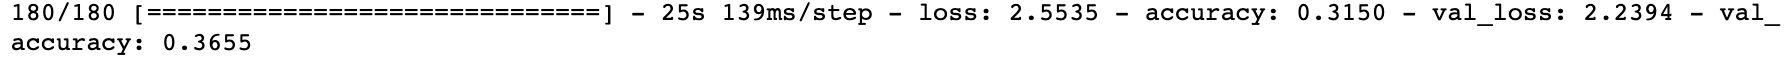

In [532]:
model.save('saved_model/allpattern_model')

INFO:tensorflow:Assets written to: saved_model/allpattern_model/assets


INFO:tensorflow:Assets written to: saved_model/allpattern_model/assets


In [92]:
model_loaded = tf.keras.models.load_model('saved_model/allpattern_model')

In [122]:
import h5py
import tempfile
import keras_util
import tensorflow as tf
from encoder.base import get_encoder_by_name
encoder = get_encoder_by_name('allpattern', 8)
from tensorflow.keras.models import load_model, save_model

In [126]:
f = h5py.File('experience_data/first_experiment.hdf5','w')

In [127]:
f.create_group('encoder')
f['encoder'].attrs['name'] = 'allpattern'
f['encoder'].attrs['board_width'] = 8
f['encoder'].attrs['board_height'] = 8
f.create_group('model')
model_loaded.save(f)

In [128]:
h5py.File('experience_data/first_experiment.hdf5')

/Users/alexlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


<HDF5 file "first_experiment.hdf5" (mode r+)>

In [133]:
f.close()

In [137]:
tensor = tf.convert_to_tensor(X_train[10])